# Wprowadzenie

**Temporal Fusion Transformer** (TFT) to architektura sieci neuronowej oparta na mechanizmie uwagi, która jest używana do prognozowania wielu punktów czasowych i osiąga wysoką wydajność. Aby uzyskać znaczący wzrost wydajności w porównaniu do najlepszych dostępnych benchmarków, autorzy wprowadzili wiele nowatorskich pomysłów, które dostosowują architekturę do pełnego zakresu potencjalnych danych wejściowych i związków czasowych, które są powszechne w prognozowaniu wielu punktów czasowych.

TFT może być trenowany z przeszłymi i przyszłymi danymi. Jest on trenowany sekwencyjnie na fragmentach o stałym rozmiarze, składających się z części enkodera i dekodera:
* encoder (przeszłe dane wejściowe o długości *input_chunk_length*)
  * przeszłe wartości docelowe **y** (obowiązkowe)
  * przeszłe kowarianty: nieznane **z** oraz znane **x** (opcjonalne)
  * statyczne zmienne towarzyszące nie zależne od czasu **s** (opcjonalne)
* decoder (przyszłe znane dane wejściowe o długości *output_chunk_length*):
  * przyszłe kowarianty **x** (obowiązkowe) - jeśli żadne nie są dostępne, należy rozważyć opcjonalne argumenty *add_encoders* lub *add_relative_index*

TFT wyświetla przedziały prognozy za pomocą kwantyli. Każdy kwantyl q prognozy τ-kroku naprzód w czasie t ma postać:

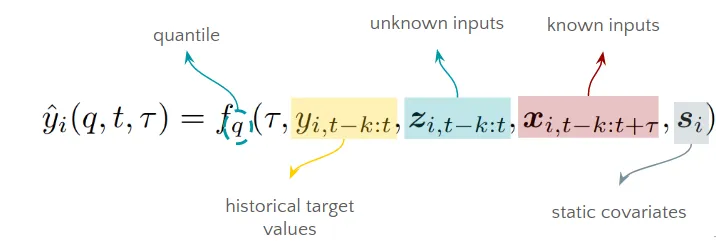


Głównymi składowymi TFT są:
* **Mechanizmy bramkowania** do pomijania nieużywanych komponentów architektury, zapewniające adaptacyjną głębokość i złożoność sieci w celu dostosowania do szerokiego zakresu zestawów danych i scenariuszy.
* **Sieci wyboru zmiennych** do wyboru odpowiednich zmiennych wejściowych w każdym kroku czasowym.
* **Enkodery cech statystycznych** do integracji statycznych zmiennych z siecią, poprzez kodowanie wektorów kontekstowych w celu uwarunkowania dynamiki czasowej.
* **Przetwarzanie czasowe** w celu uczenia się zarówno długo-, jak i krótkoterminowych zależności czasowych na podstawie zarówno obserwowanych, jak i znanych zmiennych w czasie danych wejściowych.
* **Przedziały predykcji** za pomocą prognoz kwantylowych w celu określenia zakresu prawdopodobnych wartości docelowych w każdym horyzoncie predykcji.

# Przygotowanie środowiska

In [ ]:
!pip install darts

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.models import TFTModel
from darts import TimeSeries, concatenate
import plotly.express as px
from pytorch_lightning.callbacks import EarlyStopping

# Przykład

In [2]:
from tqdm import tqdm_notebook as tqdm
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [3]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [4]:
# default quantiles for QuantileRegression
quantiles = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

# define input and output chunk length
input_chunk_length = 24
output_chunk_length = 12

# create a model
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    random_state=42
)

In [5]:
# train the TFT
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders=None, random_state=42)

In [6]:
# predict data
pred_series = my_model.predict(n=24, num_samples=200)

Predicting: |          | 0/? [00:00<?, ?it/s]

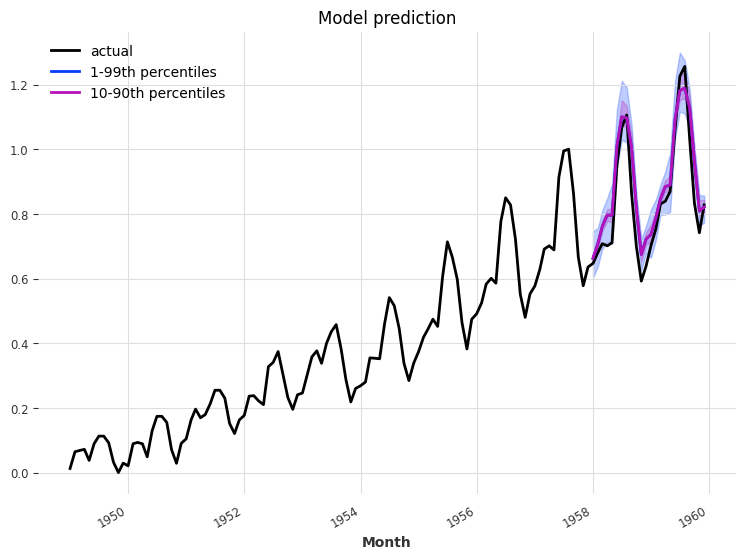

In [7]:
# plot actual series
plt.figure(figsize=(9,6))
series_transformed[: pred_series.end_time()].plot(label="actual")
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
pred_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
plt.title("Model prediction")
plt.legend()

# Ćwiczenie

Zajmiemy się predykcją notowań na giełdzie firmy Marvipol Development SA, która oferuje mieszkania i apartamenty na sprzedaż. Bazować będziemy na danych obejmujących:
* urban-one - indeks przedstawiający kształtowanie się cen transakcyjnych nieruchomości w Polsce
* średnie oprocentowanie kredytów hipotecznych
* łączną wartość pobranych kredytów hipotecznych
* średnie wynagrodzenie w Polsce

In [38]:
# wczytanie danych
mvd = pd.read_csv("./mvp_m.csv")
mvd["Data"] = pd.to_datetime(mvd["Data"])
mvd["Data"] = mvd["Data"].dt.strftime('%Y-%m')
print(mvd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        109 non-null    object 
 1   Otwarcie    109 non-null    float64
 2   Najwyzszy   109 non-null    float64
 3   Najnizszy   109 non-null    float64
 4   Zamkniecie  109 non-null    float64
 5   Wolumen     109 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 5.2+ KB
None


In [39]:
mvd.head(5)

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,2014-12,2.1201,2.3182,1.9653,2.2594,664890
1,2015-01,2.2098,2.4142,2.1913,2.3305,411389
2,2015-02,2.3119,2.3337,2.1356,2.2749,336635
3,2015-03,2.2749,2.3955,2.2006,2.3522,780255
4,2015-04,2.3522,2.5967,2.3119,2.4760,2027855


In [40]:
urbanone = pd.read_csv("./urban-one.csv", sep=";")
urbanone["date"] = pd.to_datetime(urbanone["date"])
urbanone["date"] = urbanone["date"].dt.strftime('%Y-%m')
print(urbanone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      129 non-null    object 
 1   urbanone  129 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB
None


In [41]:
urbanone.head(5)

,date,urbanone
0,2013-01,96.91
1,2013-02,96.76
2,2013-03,96.85
3,2013-04,97.09
4,2013-05,96.95


In [42]:
rates = pd.read_csv("./rates.csv", sep=";")
rates["date"] = pd.to_datetime(rates["date"])
rates["date"] = rates["date"].dt.strftime('%Y-%m')
print(rates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       107 non-null    object 
 1   avg_rate   107 non-null    float64
 2   sum_value  107 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.6+ KB
None


In [43]:
rates.head(5)

,date,avg_rate,sum_value
0,2014-12,0.0473,3191000000
1,2015-01,0.0476,2700000000
2,2015-02,0.0467,2702000000
3,2015-03,0.0443,3594000000
4,2015-04,0.0431,3552000000


In [44]:
salary = pd.read_csv("./salary.csv", sep=";")
salary["date"] = pd.to_datetime(salary["date"])
salary["date"] = salary["date"].dt.strftime('%Y-%m')
print(salary.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        226 non-null    object 
 1   avg_salary  226 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.7+ KB
None


In [45]:
salary.head(5)

,date,avg_salary
0,2005-01,2385.27
1,2005-02,2411.31
2,2005-03,2480.44
3,2005-04,2471.13
4,2005-05,2423.69


In [46]:
# prepare data
cutoff = "2014-12"
mvd = mvd[mvd.Data >= cutoff]
mvd.head(10)

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,2014-12,2.1201,2.3182,1.9653,2.2594,664890
1,2015-01,2.2098,2.4142,2.1913,2.3305,411389
2,2015-02,2.3119,2.3337,2.1356,2.2749,336635
3,2015-03,2.2749,2.3955,2.2006,2.3522,780255
4,2015-04,2.3522,2.5967,2.3119,2.4760,2027855
5,2015-05,2.4636,2.4667,2.2469,2.2594,789772
6,2015-06,2.2407,2.2872,2.0644,2.2284,373365
7,2015-07,2.2284,2.2407,2.0271,2.0983,309303
8,2015-08,2.0983,2.3830,2.0737,2.1603,2769893
9,2015-09,2.1107,2.2191,2.0737,2.1356,422420


In [47]:
urbanone = urbanone[urbanone.date >= cutoff]
urbanone.head(5)

,date,urbanone
23,2014-12,96.48
24,2015-01,95.67
25,2015-02,95.70
26,2015-03,95.85
27,2015-04,95.98


In [48]:
rates = rates[rates.date >= cutoff]
rates = rates[:-1]
rates.head(5)

,date,avg_rate,sum_value
0,2014-12,0.0473,3191000000
1,2015-01,0.0476,2700000000
2,2015-02,0.0467,2702000000
3,2015-03,0.0443,3594000000
4,2015-04,0.0431,3552000000


In [49]:
salary = salary[salary.date >= cutoff]
salary = salary[:-1]
salary.head(5)

,date,avg_salary
119,2014-12,4379.26
120,2015-01,3942.78
121,2015-02,3981.75
122,2015-03,4214.14
123,2015-04,4123.26


In [50]:
# sprecyzowanie wartości docelowych
target = TimeSeries.from_dataframe(df=mvd, time_col="Data", value_cols=["Zamkniecie"])

In [51]:
# sprecyzowanie kowariantów przeszłych i przyszłych
urbanone = TimeSeries.from_dataframe(df=urbanone, time_col='date', value_cols=['urbanone'], fill_missing_dates=True)
avg_rate = TimeSeries.from_dataframe(df=rates, time_col='date', value_cols=['avg_rate'], fill_missing_dates=True)
sum_value = TimeSeries.from_dataframe(df=rates, time_col='date', value_cols=['sum_value'], fill_missing_dates=True)
avg_salary = TimeSeries.from_dataframe(df=salary, time_col='date', value_cols=['avg_salary'], fill_missing_dates=True)

month = datetime_attribute_timeseries(target, attribute="month")
year = datetime_attribute_timeseries(target, attribute="year")

past_cov = concatenate([urbanone, avg_rate, sum_value, avg_salary], axis=1)
future_cov = concatenate([month, year], axis=1)

In [52]:
sc = Scaler()

target = sc.fit_transform(target)
past_cov = sc.fit_transform(past_cov)
future_cov = sc.fit_transform(future_cov)

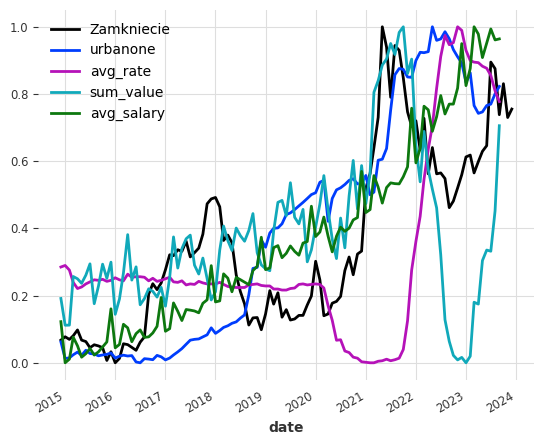

In [53]:
target.plot()
past_cov.plot()
plt.show()

In [54]:
# podział danych na traningowe i testowe
target_train, target_test = target.split_before(0.8)
past_cov_train, past_cov_test = past_cov.split_before(0.8)
future_cov_train, future_cov_test = future_cov.split_before(0.8)

In [56]:
# model
model_name = "tft_stock2"

my_stopper = EarlyStopping(
    monitor="val_loss",  # "val_MeanAbsolutePercentageError"
    patience=5,
    min_delta=0.05,
    mode='min',
)

model = TFTModel(
    input_chunk_length=12,
    output_chunk_length=3,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=4,
    batch_size=16,
    n_epochs=200,
    dropout=0.1,
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
    save_checkpoints=True,
    pl_trainer_kwargs={"accelerator": "gpu", "callbacks": [my_stopper]},
    model_name=model_name
)

In [57]:
model.fit(target_train,
          future_covariates=future_cov,
          past_covariates=past_cov,
          val_series=target_test,
          val_past_covariates=past_cov,
          val_future_covariates=future_cov)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=12, output_chunk_length=3, batch_size=16, n_epochs=200, optimizer_kwargs={'lr': 0.001}, random_state=42, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7abbe31fe290>]}, model_name=tft_stock2)

In [62]:
import os

if not os.path.exists("./models"):
    os.makedirs("./models")

# znalezienie najlepszego modelu z checkpointów
best_model = my_model.load_from_checkpoint(model_name=model_name, best=True)
best_model.save(f"./models/{model_name}.pkl")

In [59]:
# predykcja
pred = best_model.predict(n=len(target_test), num_samples=100)

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 38.64%


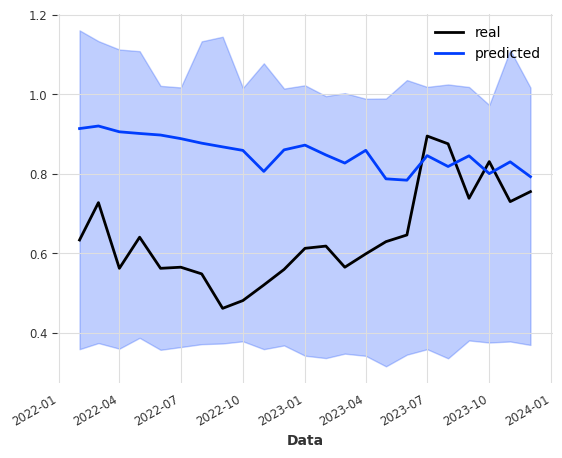

In [60]:
from darts.metrics import mape

target_test.plot(label="real")
pred.plot(label="predicted")
print("MAPE = {:.2f}%".format(mape(target, pred)))